We will be investigating EIT in a 3-level lambda steady state system with two laser beams. We will look at how varying the coupling beam and dephasing affects the absorption and dispersion characteristics of the system.

In [1]:
import numpy as np
import seaborn as sns
import qutip as qt
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
def GetNLevelBasis(numLevels):
    # use this to set basis in one line.
    lstKets = []
    for i in range(numLevels):
        lstKets.append(qt.basis(numLevels,i))
    return lstKets

In [5]:
def GetNLevelOperators(allKets):
    # use this to get transition operators in one line.
    lstOperators = []
    for ket in allKets:
        for i in range(len(allKets)):
            lstOperators.append(qt.tensor(ket*allKets[i].dag()))
    return lstOperators

In [7]:
def GetCollapseOperators(decayRates,transitionOperators):
    # use this to get dissipation operators in one line.
    lstCollapseOperators = []
    for i in range(len(decayRates)):
        lstCollapseOperators.append(np.sqrt(decayRates[i])*transitionOperators[i])
    return lstCollapseOperators

In [9]:
def NormalizeToMax(data,normFactor=1.0):
    """Normalizes a list to its maximum value.

    Args:
        data: A list of numerical values. normFactor: the value you want to normalize the values to.

    Returns:
        A new list with values normalized to the maximum value.
    """
    if not data:
        return []

    max_value = max(data)

    return [x *normFactor / max_value for x in data]

In [11]:
#     Ladder:          Lambda:                 Vee:
#                                 |three>                       |three>
#       -------|three>           -------                      -------
#          |                       / \             |two>         /
#          |                      /   \           -------       /
#          |                     /     \             \         /
#       -------|two>            /       \             \       /
#          |                   /         \             \     /
#          |                  /           \             \   /
#          |                 /        --------           \ /
#       -------|one>      -------      |two>         -------
#                          |one>                       |one>

In [13]:
class AtomicSystem():
    def __init__(self):
        self.absorptionValues = []
        self.dispersionValues = []
        self.Susceptibility = pd.DataFrame()
        
        self.detuningCouple = 0
        self.detuningProbe = 0
        self.detuningMicrowave = 0
        self.detuningRange = 0
        self.numStepsDetuning = 0
        
        self.omegaProbe = 0 
        self.omegaCouple = 0
        self.omegaMicrowave = 0

        self.decayRateProbe = 0
        self.decayRateCouple = 0
        self.decayRateMetastable = 0

        self.decayRates = []
        self.collapseOperators = []
        self.basisSet = []
        self.H = qt.Qobj()

        self.rabiRatios = []
        self.metaStableDecayRates = []

        self.numTrajectories = 0

    def GetSusceptibility(self):
        # it's faster to create and append lists and then convert to dataframe at end, rather than appending dataframe.
        tommy.absorptionValues = []
        tommy.dispersionValues = []
        
        # Set variables necessary for calculations.
        tommy.decayRates = [tommy.decayRateProbe,tommy.decayRateCouple,tommy.decayRateMetastable]
        one,two,three = GetNLevelBasis(3)    # Lambda system. level 3 is excited state.
        tommy.basisSet = [one,two,three]
        # Get all the transition operators, but note that we won't use all of them.
        sig11,sig12,sig13,sig21,sig22,sig23,sig31,sig32,sig33 = GetNLevelOperators(tommy.basisSet)

        # Get the collapse operators. This is an open system with dissipation.
        c1,c2,c3 = GetCollapseOperators(tommy.decayRates,[sig13,sig23,sig12])
        tommy.collapseOperators = [c1,c2,c3]
        detuningProbeValues = np.linspace(-tommy.detuningProbeRange,tommy.detuningProbeRange,tommy.numStepsDetuning+1)

        # Scan the probe beam and get the susceptibility values.
        scaledDetuningValues = [detuningProbe/tommy.decayRateProbe for detuningProbe in detuningProbeValues]
        for detuningProbe in scaledDetuningValues:
            tommy.detuningProbe = detuningProbe
            #   Define Hamiltonian.
            tommy.H = 0.5*qt.Qobj([[0,0,tommy.omegaProbe],
                        [0,2*(tommy.detuningProbe-tommy.detuningCouple),tommy.omegaCouple],
                        [tommy.omegaProbe,tommy.omegaCouple,2*tommy.detuningProbe]])
            rhoSteadyState = qt.steadystate(tommy.H,tommy.collapseOperators)

            tommy.absorptionValues.append(np.imag(rhoSteadyState[0,2]))
            tommy.dispersionValues.append(np.real(rhoSteadyState[0,2]))

        tommy.absorptionValues = NormalizeToMax(tommy.absorptionValues)
        tommy.dispersionValues = NormalizeToMax(tommy.dispersionValues,0.5) # dispersion values go from -0.5 to 0.5 when normalized.
        self.dfSusceptibility = (pd.DataFrame(list(zip(detuningProbeValues,tommy.absorptionValues,tommy.dispersionValues))
                ,columns=['relativeDetuning','absorptionValues','dispersionValues']))
        
        return self.dfSusceptibility
    def PlotAbsorption_VaryCoupleBeam(self):
        # some plotting preferences.
        sns.set_palette("Blues") # this helps distinguish the different plots.
        plt.figure(figsize=(10, 6))
        for rabiRatio in tommy.rabiRatios:
            tommy.omegaCouple = tommy.omegaProbe * rabiRatio
            tommy.dfSusceptibility = tommy.GetSusceptibility()
            sns.lineplot(data=tommy.dfSusceptibility,x="relativeDetuning",y="absorptionValues",
                         label =r"$\Omega_{c}$" + " = " + str(rabiRatio) + r"$\Omega_{p}$")
        plt.ylabel(r"$Im[\hat{\rho}_{13}]$")
        plt.xlabel(r"$\Delta_{13}/\gamma_{13}$")
        plt.show()
    def PlotDispersion_VaryCoupleBeam(self):
        # some plotting preferences.
        sns.set_palette("Blues") # this helps distinguish the different plots.
        plt.figure(figsize=(10, 6))
        for rabiRatio in tommy.rabiRatios:
            tommy.omegaCouple = tommy.omegaProbe * rabiRatio
            tommy.dfSusceptibility = tommy.GetSusceptibility()
            sns.lineplot(data=tommy.dfSusceptibility,x="relativeDetuning",y="dispersionValues",
                         label =r"$\Omega_{c}$" + " = " + str(rabiRatio) + r"$\Omega_{p}$")
        plt.ylabel(r"$Re[\hat{\rho}_{13}]$")
        plt.xlabel(r"$\Delta_{13}/\gamma_{13}$")
        plt.show()
    def PlotAbsorption_VaryGamma12(self):
        # some plotting preferences.
        sns.set_palette("Blues") # this helps distinguish the different plots.
        plt.figure(figsize=(10, 6))
        for metaStableDecayRate in tommy.metaStableDecayRates:
            tommy.decayRateMetastable = metaStableDecayRate * tommy.decayRateCouple # 2 -> 1 transition rate
            tommy.dfSusceptibility = tommy.GetSusceptibility()
            sns.lineplot(data=tommy.dfSusceptibility,x="relativeDetuning",y="absorptionValues",
                         label =r"$\gamma_{12}$" + " = " + str(round(metaStableDecayRate,1)) + r"$\gamma_{13}$")
        plt.ylabel(r"$Im[\hat{\rho}_{13}]$")
        plt.xlabel(r"$\Delta_{13}/\gamma_{13}$")
        plt.show()
    def PlotDispersion_VaryGamma12(self):
        # some plotting preferences.
        sns.set_palette("Blues") # this helps distinguish the different plots.
        plt.figure(figsize=(10, 6))
        for metaStableDecayRate in tommy.metaStableDecayRates:
            tommy.decayRateMetastable = metaStableDecayRate * tommy.decayRateCouple # 2 -> 1 transition rate
            tommy.dfSusceptibility = tommy.GetSusceptibility()
            sns.lineplot(data=tommy.dfSusceptibility,x="relativeDetuning",y="dispersionValues",
                         label =r"$\gamma_{12}$" + " = " + str(round(metaStableDecayRate,1)) + r"$\gamma_{13}$")
        plt.ylabel(r"$Re[\hat{\rho}_{13}]$")
        plt.xlabel(r"$\Delta_{13}/\gamma_{13}$")
        plt.show()


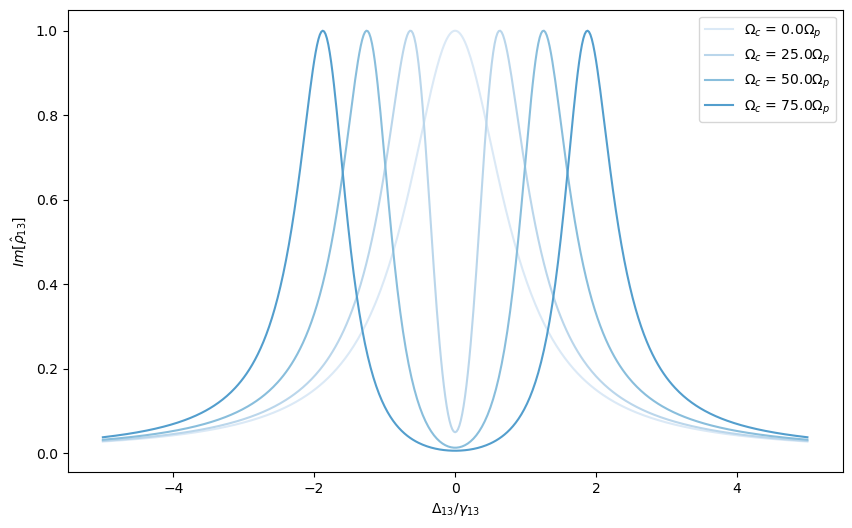

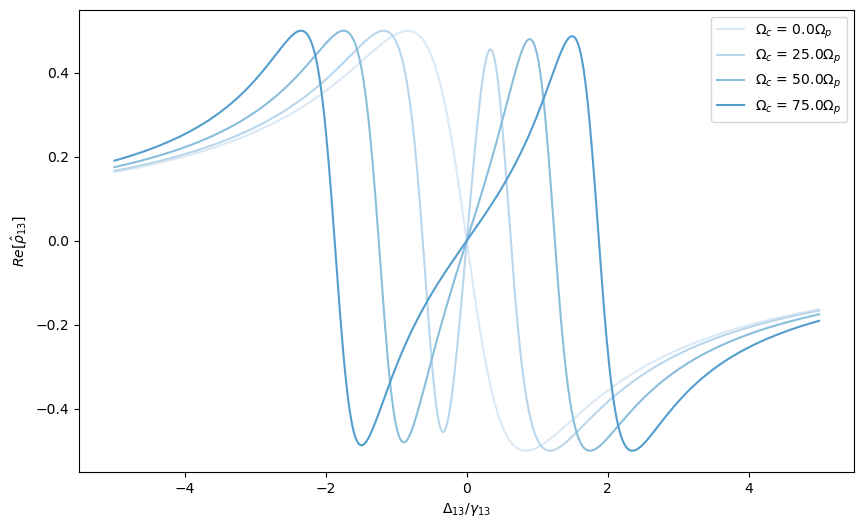

In [15]:
tommy = AtomicSystem()
'''
Ratios of coupling and probe beam. omega_couple = rabiRatio* omega_probe. There will be a series plotted for each ratio.
'''
tommy.rabiRatios = np.linspace(0,75,4) 
tommy.numStepsDetuning = 500 # the more steps, the better the resolution. we are scanning the detuning of the probe beam.

'''
These are properties of the system. Varying these values gives insights to EIT behavior.
'''
#   Decay rates.
tommy.decayRateProbe = 1 # 3 -> 1 transition rate
tommy.decayRateCouple = 2.0/3.0 # 3 -> 2 transition rate
tommy.decayRateMetastable = np.sqrt(.005)* tommy.decayRateCouple # 2 -> 1 transition rate
    
tommy.omegaProbe = 0.05* tommy.decayRateProbe    # Rabi frequency for probe beam. This beam is generally weaker than coupling beam.

tommy.detuningCouple = 0.0   # Coupling beam is generally on resonance while we scan the probe beam.
tommy.detuningProbeRange = 5 # magnitude of the detuning that will be scanned for the probe beam.   

tommy.PlotAbsorption_VaryCoupleBeam()
tommy.PlotDispersion_VaryCoupleBeam()

As omega for the coupling beam is increased, the transparency window widens and the dispersion becomes less steep. Next lets hold the coupling beam constant, and see what happens when we change the spontaneous emission rate for the |2> -> |1> transition.

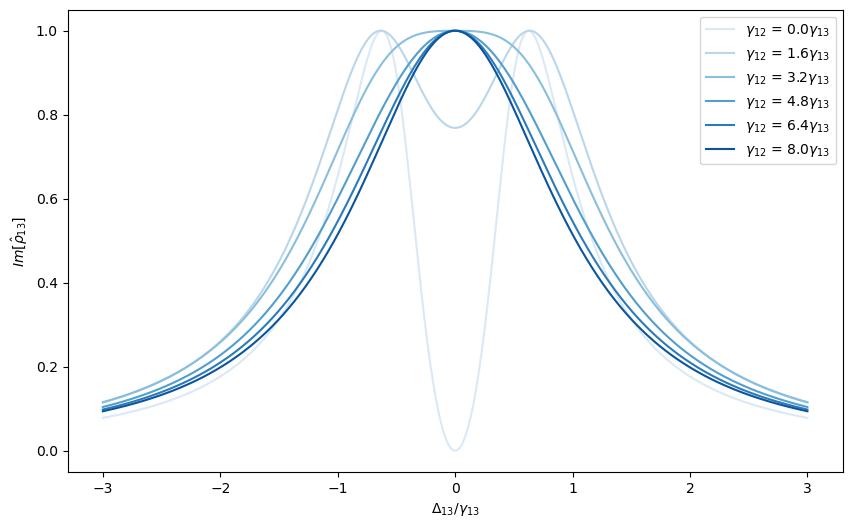

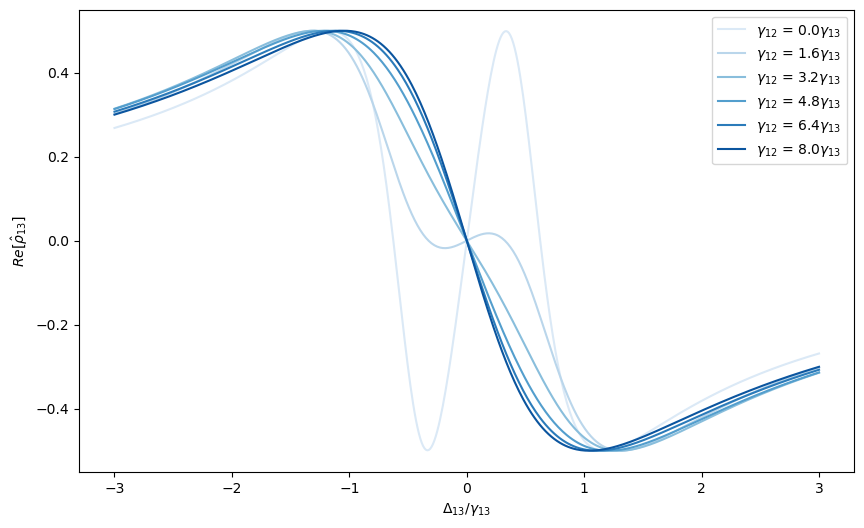

In [18]:
tommy = AtomicSystem()
'''
This time let's see how changing gamma_12 affects our system.
'''
tommy.metaStableDecayRates = np.linspace(0,8,6) 
tommy.numStepsDetuning = 500 # the more steps, the better the resolution. we are scanning the detuning of the probe beam.
'''
These are properties of the system. Varying these values gives insights to EIT behavior.
'''
#   Decay rates.
tommy.decayRateProbe = 1 # 3 -> 1 transition rate
tommy.decayRateCouple = 2.0/3.0 # 3 -> 2 transition rate
tommy.decayRateMetastable = .0001* tommy.decayRateCouple # 2 -> 1 transition rate
    
tommy.omegaProbe = 0.05* tommy.decayRateProbe    # Rabi frequency for probe beam. This beam is generally weaker than coupling beam.
tommy.omegaCouple = 25*tommy.omegaProbe # coupling beam is stronger than probe beam.
tommy.detuningCouple = 0.0   # Coupling beam is generally on resonance while we scan the probe beam.
tommy.detuningProbeRange = 3 # magnitude of the detuning that will be scanned for the probe beam.   

tommy.PlotAbsorption_VaryGamma12()
tommy.PlotDispersion_VaryGamma12()

We see that increasing the dephasing rate (gamma_12) increases decoherence. When gamma_12 is small, we see EIT effects, but those effects diminish as gamma_12 increases.